LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)
Epoch 0: training loss: 0.910046017964681, accuracy: 82.96041666666667
Epoch 1: training loss: 0.6819387732346852, accuracy: 85.29166666666667
Epoch 2: training loss: 0.5888491766452789, accuracy: 86.28333333333333
Epoch 3: training loss: 0.5364098771413167, accuracy: 87.00833333333333
Epoch 4: training loss: 0.5019895770549774, accuracy: 87.52499999999999
NonlinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
  )
)
Epoch 0: training loss: 2.0166860332489014, accuracy: 51.74583333333334
Epoch 1: training loss: 1.066702054977417, accuracy: 76.2625
Epoch 2: training loss: 0.6480263883272807, accuracy: 82.9354

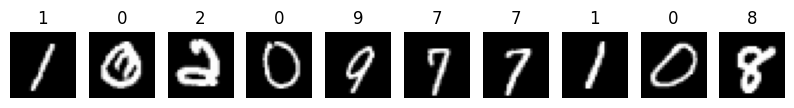

In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn
import numpy
import matplotlib.pyplot as plt

# Define the evaluate function
def evaluate(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100 * correct
    return accuracy, loss

# Download MNIST dataset
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# Split the training data into training and validation sets
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

# Set batch size
batch_size = 128

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

# Define Linear Classifier
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer_1 = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer_1(x)
        return x

# Instantiate the linear model
linear_model = LinearClassifier()
print(linear_model)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.01)

# Training the linear model
epochs = 5
for j in range(epochs):
    for batch, (X, y) in enumerate(train_dataloader):
        # Forward pass
        pred = linear_model(X)
        loss = loss_fn(pred, y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()

    # Checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

# Visualize how the model is doing on the first 10 examples
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(batch[0][i, 0, :, :], cmap="gray")
    plt.title('%d' % predictions[i, :].argmax())

# Define Nonlinear Classifier
class NonlinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28 * 28, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)
        return x

# Instantiate the nonlinear model
nonlinear_model = NonlinearClassifier()
print(nonlinear_model)

# Define loss function and optimizer
loss_fn_nonlinear = nn.CrossEntropyLoss()
optimizer_nonlinear = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01)

# Training the nonlinear model
epochs = 5
for j in range(epochs):
    for batch, (X, y) in enumerate(train_dataloader):
        # Forward pass
        pred = nonlinear_model(X)
        loss = loss_fn_nonlinear(pred, y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer_nonlinear.step()

        # Reset gradients
        optimizer_nonlinear.zero_grad()

    # Checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn_nonlinear)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

# Evaluate the nonlinear model on validation data
acc_val_nonlinear, loss_val_nonlinear = evaluate(val_dataloader, nonlinear_model, loss_fn_nonlinear)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val_nonlinear, acc_val_nonlinear))

# Evaluate the nonlinear model on test data
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
acc_test_nonlinear, loss_test_nonlinear = evaluate(test_dataloader, nonlinear_model, loss_fn_nonlinear)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test_nonlinear, acc_test_nonlinear))
